In [2]:
#import os, os.path
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.optim as optim
from tqdm.notebook import trange, tqdm
from PIL import Image
# force gpu computing, when gpu library is available
USE_GPU = True
# for timing
import datetime as dt

In [3]:
from train_loop import train, train_for_epochs, validate, plot_history

ModuleNotFoundError: No module named 'train_loop'

---

## Implementing a deep convolutional neural network (MNIST)
---

### The multilayer CNN architecture
* also see [Stanford University's CS231n](https://cs231n.github.io/convolutional-networks/) (recommended read)
* concerning *pooling* in particular, see also [Jason Brownlee's blog](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) (also recommended)

<img src="./15_12.png" width=700/>

### Loading and preprocessing the data
* directly from available [*Torchvision Datasets*](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html)
* might take a while when first loaded, but can be reused afterwards
* parameter `root` is used to specify a local directory to put the data in
* parameter `train` is used to specify whether data is to be used for training or testing the model
* parameter `transform` is used to provide transformation logic. In this case we use the [ToTensor()](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor) transformation. This converts the image to a Ptorch tensor and scales its values to the range [0.0, 1.0]

In [4]:
start_mnist_normal = dt.datetime.now()
print(f'MNIST loading started: {start_mnist_normal}')
## MNIST dataset
mnist_train = MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

#split of 10000 entries from the train data set as validation data set
val_size = 10000
train_size = len(mnist_train) - val_size
mnist_train, mnist_valid = random_split(mnist_train, [train_size, val_size])

finish_mnist_normal = dt.datetime.now()
print(f'MNIST normalization finished {finish_mnist_normal} (duration: {finish_mnist_normal - start_mnist_normal})')
print(f'Len train dataset: {len(mnist_train)} -- Len test dataset: {len(mnist_test)} -- Len val dataset: {len(mnist_valid)}')

MNIST loading started: 2024-10-16 20:47:20.395901
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 9912422/9912422 [00:02<00:00, 3972752.33it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 28881/28881 [00:00<00:00, 277115.95it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 1648877/1648877 [00:00<00:00, 1936063.93it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 4542/4542 [00:00<00:00, 2004685.76it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

MNIST normalization finished 2024-10-16 20:47:35.005541 (duration: 0:00:14.609640)
Len train dataset: 50000 -- Len test dataset: 10000 -- Len val dataset: 10000


#### Setting some hyperparameters and loading data

In [4]:
%%capture
# use %%capture to suppress unwanted output
BATCH_SIZE = 64
torch.manual_seed(42)

In [5]:
# convert the dataset to a dataloader which handles batching of the data
mnist_trainloader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_valloader = DataLoader(mnist_valid, batch_size=BATCH_SIZE, shuffle=False)
mnist_testloader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

### Implementing a CNN using PyTorch

#### Hyperparameters for CNN layers in PyTorch

 * **[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):** `torch.nn.Conv2Dd`
   * `in_channels`: Number of channels in the input image
   * `out_channels `: Number of channels produced by the convolution
   * `kernel_size`: form of receptive field
   * `strides`: size of filter shifts
   * `padding`: number of padded input fields $\rightarrow$ *dimension* of layer-output
   
   
 * **[MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html):** `torch.nn.MaxPool2d`
   * `kernel_size`: $\rightarrow$ *dimensionality reduction* (in conjunction with `strides`)
   * `strides`
   * `padding`
   
   
 * **[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)** `torch.nn.Dropout`
   * `p`: probability to drop a neuron

### Building a CNN with PyTorch

In [5]:
# define the model by implementing it as a python class. Note we have to implement the nn.Module
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Instantiating and showing the model structure:

In [6]:
# Create an instance of the CNN model
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

**Question**: How many parameters (disregarding bias) does this CNN learn?

### Model training
As before, we will just use the go-to-criterion of `CrossEntropyLoss` in connection with the `Adam` optimizer. For an overview of existing optimization algorithms, have a look [here](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/). However, we start by training for *just one epoch*, i.e., we present the entirety of the training data to the model for learning only once and we will check how well the model performs afterwards.

In [7]:

NUM_EPOCHS = 10

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device} for training the network')

# Move the model weights to the desired device
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

start_train_mnist = dt.datetime.now()

print(f'MNIST training started: {start_train_mnist}')
# run training, set binary to false since we have a multi label classification
history = train_for_epochs(device, NUM_EPOCHS, model, mnist_trainloader, mnist_valloader, optimizer, criterion, binary=False)

finish_train_mnist = dt.datetime.now()
print(f'MNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

Using cuda for training the network
MNIST training started: 2024-10-16 20:47:56.014261


NameError: name 'train_for_epochs' is not defined

#### Model quality
Let's see how well the model did during training already and in particular, how well it generalizes to the unseen test data after just one epoch.

In [9]:
train_acc = history['train']['accuracy'][0]
val_acc = history['val']['accuracy'][0]
_, test_acc = validate(device, model, mnist_testloader, criterion, binary=False)
print(f'\nTrain Acc. {train_acc:.2f}\nVal Acc. {val_acc:.2f}\nTest Acc. {test_acc:.2f}')


Train Acc. 94.90
Val Acc. 98.29
Test Acc. 99.35


So, due to the superior network architecture which is much better suited to the task at hand, it took just a few seconds of training to obtain a model performing much better than the general MLP we already looked at. What is also interesting: should you continue to train the model (see the next example below), you could stop after only 3 epochs, since at that point the validation accuracy will already be above 99% and will more or less stagnate from there on, while the training accuracy will continue to (marginally) increase. This just shows that the model starts memorizing the training data instead of becoming better on unseen data quite fast.

#### Classification of selected images

In [10]:
# function for predicting the class for a given batch by a trained model
def predict_batch(model, batch, binary=True):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        #predict
        outputs = model(batch)
        # Get the prediction by selecting the class with the highest probability
        if binary:
#            predicted = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
        else:
#            predicted = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu(), outputs.cpu()

batch_test = next(iter(mnist_testloader))

preds, _ = predict_batch(model, batch_test[0][:12], binary=False)
print((batch_test[0][1].shape))
print(preds)

torch.Size([1, 28, 28])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6])


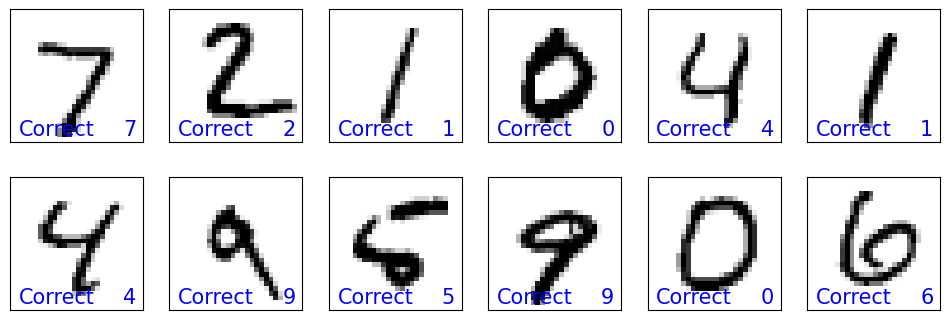

In [11]:
# visual check
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(12, 4))
    for i in range(12):
        correct = preds[i] == batch_test[1][i]
        ax = fig.add_subplot(2, 6, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][i].view(28, 28)
        ax.imshow(img, cmap='gray_r')
        ax.text(0.9, 0.1, '{}'.format(preds[i]), 
                size=15, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.35, 0.1, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=15, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()

## Export Model

In [12]:


torch.onnx.export(
    model,                   # Model to export
    torch.rand(1,1,28,28).to(device),             # Input tensor for the model
    "cnnModelMnist.onnx",          # Output file name
    export_params=True,      # Store the trained parameter weights
    opset_version=11,        # ONNX version (11 is a safe default)
    do_constant_folding=True,# Constant folding for optimization
    input_names=['input'],   # Input name (optional)
    output_names=['output'], # Output name (optional)
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}} # Enable dynamic batch size
)

In [13]:
# do this, especially if you do not have a lot of VRAM
torch.cuda.empty_cache()

In [14]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model_path = "cnnModelMnist.onnx"  # Replace with your ONNX model path
session = ort.InferenceSession(onnx_model_path)

# Print model input/output details
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print(f"Model input name: {input_name}")
print(f"Model output name: {output_name}")

# Create a dummy input to test the model
# For example, if your model expects a tensor of shape (1, 1, 28, 28) like a CNN for MNIST
# Get the input image tensor
input_tensor = batch_test[0][3]  # Shape: [1, 28, 28]

# Add a batch dimension to make it [1, 1, 28, 28]
input_tensor = input_tensor.unsqueeze(0)  # Shape: [1, 1, 28, 28]
#print(input_tensor)

# Convert the PyTorch tensor to a NumPy array (since ONNX runtime uses NumPy)
input_numpy = input_tensor.numpy().astype(np.float32)



# Run the model
output = session.run([output_name], {input_name: input_numpy})

# Get the output tensor
output_tensor = output[0]

# Display the output tensor size and contents
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Output tensor contents: \n{output_tensor}")

Model input name: input
Model output name: output
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0